# -----
# FIG S6 in RECCAP SO paper
# -----
#
# Plot climate effect on natural and anthropogenic CO2 fluxes
# 
# Contact: cara.nissen@awi.de or cara.nissen@colorado.edu
#
# version: August 2023
#

In [1]:
### modules
import os
import numpy as np
import seawater as sw
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm 
from datetime import date, timedelta
import copy
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from annualmean import annualmean

In [2]:
#-----
# SETTINGS
# define paths to all data
# define where to save plots (if any)
# define years to average over
#-----

# data sets
path1 = '/pscratch/sd/c/cnissen/RECCAPv2/'
path_models = path1+'reccap_submissions/download_20220124/Models/2D_CO2/' 
path_data   = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_atminv = path1+'reccap_submissions/download_20220124/Atmospheric_inversions/'
path_soccom = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_trend  = path1+'reccap_submissions/download_20220124/Models/Linear_trends/' 

# river flux adjustment
path_river  = path1+'masks_reccap/river_flux_adjustment/'

# path to RECCAP SO mask
path_mask = path1+'masks_reccap/'

#----
# specify years to average over
#----
# NOTE: the script is written to plot avrages over 1985-2018
#    the years are defined here for plot titles and filenames 
year1,year2 = 1985,2018 
eval_time   = np.arange(year1,year2+1) 

#----
# define simulation
#----
sim = 'A'

#----
# define where to save plots
#----
save_to_dir ='/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig3/Suppl_climate_effect_only/'
if not os.path.exists(save_to_dir):
    print ('Created '+save_to_dir)
    os.makedirs(save_to_dir)
    

Created /global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig3/Suppl_climate_effect_only/


In [3]:
#------
# define a separate list of models for each of the components to plot
#------
# which models are only availalbe for simA and simB?
# FESOM_HR, MOM6
# which models are only availalbe for simA,simB, and simD?
# ROMS

# variable name of interest
var = '2D_CO2'

models_A  = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
versionID_models_A     = ('20211125','v20211122','v20211208','v20220323','v20211119','v20211119',\
                       'v20220125','v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 

models_AD = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_LR',\
             'MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
versionID_models_AD    = ('20211125','v20211122','v20211208','v20220323','v20211119',\
                       'v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 

models_AC = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_LR',\
             'MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12')
versionID_models_AC    = ('20211125','v20211122','v20211208','v20220323','v20211119',\
                       'v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404') 

models_CB = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_LR',\
             'MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12') 
versionID_models_CB    = ('20211125','v20211122','v20211208','v20220323','v20211119',\
                       'v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404') 

models_D  = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_LR',\
             'MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
versionID_models_D     = ('20211125','v20211122','v20211208','v20220323','v20211119',\
                       'v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 

subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')

print ('Models w/ all 4 simulations:',len(models_A),len(versionID_models_A))



Models w/ all 4 simulations: 14 14


In [4]:
#----
# FUNCTIONS
#----

# transform longitude (e.g., go from -179.5:179.5 to 0.5:359.5)
def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    # for 3D arrays: assume lon coordinate to be the 3rd dimension  
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180] = data[:,180:]
        data_transformed[:,180:]  = data[:,0:180] 
    elif len(data.shape)==3:
        data_transformed          = np.empty_like(data)
        try:
            data_transformed[:,:,0:180] = data[:,:,180:]
            data_transformed[:,:,180:]  = data[:,:,0:180]
        except:
            data_transformed[:,0:180,:] = data[:,180:,:]
            data_transformed[:,180:,:]  = data[:,0:180,:] 
    elif len(data.shape)==4:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180,:,:] = data[:,180:,:,:]
        data_transformed[:,180:,:,:]  = data[:,0:180,:,:] 
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        data_transformed[0:180] = data[180:]
        data_transformed[180:]  = data[0:180]
    return data_transformed


In [5]:
#------
# load RECCAP mask for SO
# make sure region mask matches the submitted products in terms of longitude!
#------

# SO RECCAP regions
#reccap_mask_SO   = Dataset(path_mask+'RECCAP2_region_masks_all_v20221025.nc')
#regions          = reccap_mask_SO_2.variables['southern'][:,:] #"1.SO STSS, 2.SO SPSS, 3.SO ICE"
#lon_regions      = reccap_mask_SO_2.variables['lon'][:]
#print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)
#print(np.min(regions_2),np.max(regions_2))

# SO RECCAP regions
reccap_mask_SO = Dataset(path_mask+'reccap_regions_SOsubs.nc')
regions        = reccap_mask_SO.variables['SO_basins_biomes'][:,:]
lon_regions    = reccap_mask_SO.variables['lon'][:]
print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)

# lon in file is -180:180 -> want 0-360, so transform here
regions = transform_lon_coord(regions)
print(np.min(regions),np.max(regions))


-179.5 179.5
0.0 8.0


In [6]:
#-----
# load data
#-----

years_in_file = np.arange(1980,2018+1)

# components to load -> set all to true for Fig. S6 in paper
load_anth_ns_nat_ns = True  # simA-simC; "total climate effect"
load_anth_ns        = True  # simA-simC-simD+simB; "climate effect on anthropogenic carbon"
load_nat_ns         = True  # simD-simB; "climate effect on natural carbon"

#-----
# models: simA-simC-simD+simB
#-----
if load_anth_ns:
    flux_models_anth_ns = np.nan*np.ones([180,360,len(eval_time),len(models_AC)])
    for ii in range(0,len(models_AC)):
        print ('Load simA, simB, simC & simD of '+models_AC[ii])
        ffD = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_D_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
        ffC = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_C_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
        ffB = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_B_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
        ffA = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_A_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
        dataD = np.squeeze(ffD.variables['fgco2'][:,:,:])
        dataC = np.squeeze(ffC.variables['fgco2'][:,:,:])
        dataB = np.squeeze(ffB.variables['fgco2'][:,:,:])
        dataA = np.squeeze(ffA.variables['fgco2'][:,:,:])
        dataD = annualmean(dataD)
        dataC = annualmean(dataC)
        dataB = annualmean(dataB)
        dataA = annualmean(dataA)
        if models_AC[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
            dataD = -1*dataD[22:,:,:] # flip sign
            dataC = -1*dataC[22:,:,:] # flip sign
            dataB = -1*dataB[22:,:,:] # flip sign
            dataA = -1*dataA[22:,:,:] # flip sign
        if models_AC[ii] in ['MPIOM-HAMOCC']: # kick out 2019
            dataD = dataD[:-1,:,:]
            dataC = dataC[:-1,:,:]
            dataB = dataB[:-1,:,:]
            dataA = dataA[:-1,:,:]
        try: 
            dataD[dataD.mask==True]=np.nan
            dataC[dataC.mask==True]=np.nan
            dataB[dataB.mask==True]=np.nan
            dataA[dataA.mask==True]=np.nan
        except: 
            pass
        
        # find position into which to write annual means (depends on years provided in submission)
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
        else:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        #print start_ind,end_ind
        
        dataD = np.transpose(dataD,[1,2,0])
        dataC = np.transpose(dataC,[1,2,0])
        dataB = np.transpose(dataB,[1,2,0])
        dataA = np.transpose(dataA,[1,2,0])
        #simA-simC-simD+simB
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            flux_models_anth_ns[:,:,:end_ind+1,ii] = dataA[:,:,start_ind:]-dataC[:,:,start_ind:]-\
                                dataD[:,:,start_ind:]+dataB[:,:,start_ind:]
        else: 
            flux_models_anth_ns[:,:,:,ii] = dataA[:,:,start_ind:end_ind+1]-dataC[:,:,start_ind:end_ind+1]-\
                        dataD[:,:,start_ind:end_ind+1]+dataB[:,:,start_ind:end_ind+1]
        #print data.shape
        ffD.close()
        ffC.close()
        ffB.close()
        ffA.close()
        del dataD,dataC,dataB,dataA
        
        
        
#-----
# models: simD-simB
#-----
if load_nat_ns:
    flux_models_nat_ns = np.nan*np.ones([180,360,len(eval_time),len(models_AC)])
    for ii in range(0,len(models_AC)):
        print ('Load simD & simB of '+models_AC[ii])
        ffD = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_D_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
        ffB = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_B_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
        dataD = np.squeeze(ffD.variables['fgco2'][:,:,:])
        dataB = np.squeeze(ffB.variables['fgco2'][:,:,:])
        dataD = annualmean(dataD)
        dataB = annualmean(dataB)
        if models_AC[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
            dataD = -1*dataD[22:,:,:] # flip sign
            dataB = -1*dataB[22:,:,:] # flip sign
        if models_AC[ii] in ['MPIOM-HAMOCC']: # kick out 2019
            dataD = dataD[:-1,:,:]
            dataB = dataB[:-1,:,:]
        try: 
            dataD[dataD.mask==True]=np.nan
            dataB[dataB.mask==True]=np.nan
        except: 
            pass
        
        # find position into which to write annual means (depends on years provided in submission)
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
        else:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        #print start_ind,end_ind
        
        dataD = np.transpose(dataD,[1,2,0])
        dataB = np.transpose(dataB,[1,2,0])
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            flux_models_nat_ns[:,:,:end_ind+1,ii] = dataD[:,:,start_ind:]-dataB[:,:,start_ind:]
        else: 
            flux_models_nat_ns[:,:,:,ii] = dataD[:,:,start_ind:end_ind+1]-dataB[:,:,start_ind:end_ind+1]
        #print data.shape
        ffD.close()
        ffB.close()
        del dataD,dataB
        
        
#-----
# models: simA-simC
#-----
if load_anth_ns_nat_ns:
    flux_models_anth_ns_nat_ns = np.nan*np.ones([180,360,len(eval_time),len(models_AC)])
    for ii in range(0,len(models_AC)):
        print ('Load simA & simC of '+models_AC[ii])
        ffA = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_A_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
        ffC = Dataset(path_models+models_AC[ii]+'_'+var+'_'+versionID_models_AC[ii]+'/'+\
                    'fgco2_'+models_AC[ii]+'_C_1_gr_1980-2018_'+versionID_models_AC[ii]+'.nc')
        dataA = np.squeeze(ffA.variables['fgco2'][:,:,:])
        dataC = np.squeeze(ffC.variables['fgco2'][:,:,:])
        dataA = annualmean(dataA)
        dataC = annualmean(dataC)
        if models_AC[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
            dataA = -1*dataA[22:,:,:] # flip sign
            dataC = -1*dataC[22:,:,:] # flip sign
        if models_AC[ii] in ['MPIOM-HAMOCC']: # kick out 2019
            dataA = dataA[:-1,:,:]
            dataC = dataC[:-1,:,:]
        try: 
            dataA[dataA.mask==True]=np.nan
            dataC[dataC.mask==True]=np.nan
        except: 
            pass
        
        # find position into which to write annual means (depends on years provided in submission)
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.argmin(np.abs(eval_time-2017)) 
        else:
            start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
            end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        #print start_ind,end_ind
        
        dataA = np.transpose(dataA,[1,2,0])
        dataC = np.transpose(dataC,[1,2,0])
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
            flux_models_anth_ns_nat_ns[:,:,:end_ind+1,ii] = dataA[:,:,start_ind:]-dataC[:,:,start_ind:]
        else: 
            flux_models_anth_ns_nat_ns[:,:,:,ii] = dataA[:,:,start_ind:end_ind+1]-dataC[:,:,start_ind:end_ind+1]
        #print data.shape
        ffA.close()
        ffC.close()
        del dataA,dataC
        
print ('done')


Load simA, simB, simC & simD of CCSM-WHOI
Load simA, simB, simC & simD of CESM-ETHZ
Load simA, simB, simC & simD of CNRM-ESM2-1
Load simA, simB, simC & simD of EC-Earth3
Load simA, simB, simC & simD of FESOM_REcoM_LR


/global/u2/c/cnissen/scripts_reccap/annualmean.py:43: RuntimeWarning: Mean of empty slice
  var_annualmean[t,:,:] = np.nanmean(datamB, axis=0)


Load simA, simB, simC & simD of MPIOM-HAMOCC
Load simA, simB, simC & simD of MRI-ESM2-1
Load simA, simB, simC & simD of NorESM-OC1.2
Load simA, simB, simC & simD of ORCA025-GEOMAR
Load simA, simB, simC & simD of ORCA1-LIM3-PISCES
Load simA, simB, simC & simD of PlankTOM12
Load simD & simB of CCSM-WHOI
Load simD & simB of CESM-ETHZ
Load simD & simB of CNRM-ESM2-1
Load simD & simB of EC-Earth3
Load simD & simB of FESOM_REcoM_LR
Load simD & simB of MPIOM-HAMOCC
Load simD & simB of MRI-ESM2-1
Load simD & simB of NorESM-OC1.2
Load simD & simB of ORCA025-GEOMAR
Load simD & simB of ORCA1-LIM3-PISCES
Load simD & simB of PlankTOM12
Load simA & simC of CCSM-WHOI
Load simA & simC of CESM-ETHZ
Load simA & simC of CNRM-ESM2-1
Load simA & simC of EC-Earth3
Load simA & simC of FESOM_REcoM_LR
Load simA & simC of MPIOM-HAMOCC
Load simA & simC of MRI-ESM2-1
Load simA & simC of NorESM-OC1.2
Load simA & simC of ORCA025-GEOMAR
Load simA & simC of ORCA1-LIM3-PISCES
Load simA & simC of PlankTOM12
done


In [7]:
#---
# print some numbers (to spot any obvious problems)
#---

if load_anth_ns_nat_ns:
    print ('-----')
    print ('anth,ns + natural,ns')
    print ('-----')
    for ii in range(0,len(models_AC)):
        print (models_AC[ii]+': '+str(np.nanmin(flux_models_anth_ns_nat_ns[:,:,:,ii]))+' '+\
                str(np.nanmax(flux_models_anth_ns_nat_ns[:,:,:,ii])))
            
if load_nat_ns:
    print ('-----')
    print ('natural,ns')
    print ('-----')
    for ii in range(0,len(models_AC)):
        print (models_AC[ii]+': '+str(np.nanmin(flux_models_nat_ns[:,:,:,ii]))+' '+\
                str(np.nanmax(flux_models_nat_ns[:,:,:,ii])))
            
if load_anth_ns:
    print ('-----')
    print ('anth,ns')
    print ('-----')
    for ii in range(0,len(models_AC)):
        print (models_AC[ii]+': '+str(np.nanmin(flux_models_anth_ns[:,:,:,ii]))+' '+\
                str(np.nanmax(flux_models_anth_ns[:,:,:,ii])))
         

-----
anth,ns + natural,ns
-----
CCSM-WHOI: -1.3021198697060754e-07 8.646205174045463e-08
CESM-ETHZ: -1.1518460407700104e-07 1.0032389186065416e-07
CNRM-ESM2-1: -3.1756784658992126e-07 4.800097998960818e-07
EC-Earth3: -2.2781846809039052e-07 1.730012684220128e-07
FESOM_REcoM_LR: -3.2292498258155504e-07 3.3850967450134415e-07
MPIOM-HAMOCC: -2.2986834657956479e-07 1.521816734850745e-07
MRI-ESM2-1: -2.0315680160365446e-07 2.74525007171178e-07
NorESM-OC1.2: -1.517958594376978e-07 1.8602264617584297e-07
ORCA025-GEOMAR: -2.4717844915438584e-07 3.008949778744884e-07
ORCA1-LIM3-PISCES: -2.196959467681836e-07 1.7093007897983625e-07
PlankTOM12: -1.527138380197357e-07 2.0464351280224946e-07
-----
natural,ns
-----
CCSM-WHOI: -1.4336183618013365e-07 8.093628878214076e-08
CESM-ETHZ: -1.3988904434825145e-07 9.762441965932567e-08
CNRM-ESM2-1: -4.94675238922257e-07 2.965115936949112e-07
EC-Earth3: -2.9126197986784064e-07 1.7827914433610204e-07
FESOM_REcoM_LR: -3.302297402916759e-07 3.034059901441896e-0

In [8]:
#------
# get surface area of all the biomes
#------
# calculate area with sw.dist

def get_areas_biomes(area,regions,subregions):
    # calculate area-weighted averages of a given quantity in data according to biomes defined
    # after Fay & McKinley (2014), use RECCAP mask loaded further up
    # provide "area" (with lon from 0:360)
    
    # only consider area for SO RECCAP mask
    area[regions.mask==True]=0
    print ('Total Southern Ocean ocean surface area '+str(np.nansum(area))+' m2')
    
    data_avg = np.zeros(13) # 9 regions in SO, + 3 for combined sectors, +1 for whole SO
    for i in range(0,13):
        reg2  = regions.ravel()
        area2 = area.ravel()
        if subregions[i] in ['STSS-Atl']:
            ind_region = np.where(reg2==0)[0]
        elif subregions[i] in ['STSS-Ind']:
            ind_region = np.where(reg2==3)[0]
        elif subregions[i] in ['STSS-Pac']:
            ind_region = np.where(reg2==6)[0]
        elif subregions[i] in ['SPSS-Atl']:
            ind_region = np.where(reg2==1)[0]
        elif subregions[i] in ['SPSS-Ind']:
            ind_region = np.where(reg2==4)[0]
        elif subregions[i] in ['SPSS-Pac']:
            ind_region = np.where(reg2==7)[0]
        elif subregions[i] in ['ICE-Atl']:
            ind_region = np.where(reg2==2)[0]
        elif subregions[i] in ['ICE-Ind']:
            ind_region = np.where(reg2==5)[0]
        elif subregions[i] in ['ICE-Pac']:
            ind_region = np.where(reg2==8)[0]
        elif subregions[i] in ['STSS']:
            ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
        elif subregions[i] in ['SPSS']:
            ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
        elif subregions[i] in ['ICE']:
            ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
        elif subregions[i] in ['all']:
            ind_region = np.where(reg2>=0)[0]
        data_avg[i] = np.nansum(area2[ind_region]) #np.nansum(data2[ind_region]*area2[ind_region]/total_area)
        del reg2, area2,ind_region
    return data_avg

# define for filtering, but don't use for area calculation
lon = np.arange(0.5,359.5+1,1)
lat = np.arange(-89.5,89.5+1,1)

# need the box boundaries for area calculation
xi = np.arange(0,360+1,1)
yi = np.arange(-90,90+1,1) 

area = np.zeros((len(xi)-1,len(yi)-1))
#calculate area
for i in range(0,len(xi)-1): #laenge pruefen!
    if i==np.round(len(xi)/2): 
        print ('50% done')
    for j in range(0,len(yi)-1): 
        dist1 = sw.dist([yi[j],yi[j+1]],[xi[i],xi[i]])
        dist2 = sw.dist([yi[j],yi[j]],[xi[i],xi[i+1]])
        area[i][j] = float(dist1[0]) * float(dist2[0]) *1000 *1000 #m2
area = area.transpose()
print ('Global area:',np.sum(area),'m2') 
area_global = np.copy(area)

area_biomes = get_areas_biomes(area,regions,subregions)

#print (area_biomes)
print('TEST: the following three should be identical')
print (np.sum(area_biomes[0:9])) # 9 subregions
print (np.sum(area_biomes[9:12])) # 3 subregions
print (np.sum(area_biomes[12])) # 1 subregion 


50% done
Global area: 509364377985322.94 m2
Total Southern Ocean ocean surface area 77409028462219.4 m2
TEST: the following three should be identical
77409028462219.4
77409028462219.42
77409028462219.42


In [9]:
#-----
# get subareas avg
#-----

def get_subarea_avg(flux_models,regions,area,eval_time,models_ABCD,subregions):
    flux_subareas  = np.nan*np.ones([len(eval_time),len(models_ABCD),len(subregions)])
    biome_areas    = np.nan*np.ones([len(models_ABCD),len(subregions)]) 
    for pp in range(0,len(models_ABCD)):
        counter=0 # only for printing of total area
        print ('Process '+models_ABCD[pp])
        for i in range(0,len(subregions)):
            for yy in range(0,len(eval_time)):
                data1 = flux_models[:,:,yy,pp]
                reg2  = regions.ravel()  # SO RECCAP mask
                area2 = area.ravel() # surface area
                data2 = data1.ravel()
                if subregions[i] in ['STSS-Atl']:
                    ind_region = np.where(reg2==0)[0]
                elif subregions[i] in ['STSS-Ind']:
                    ind_region = np.where(reg2==3)[0]
                elif subregions[i] in ['STSS-Pac']:
                    ind_region = np.where(reg2==6)[0]
                elif subregions[i] in ['SPSS-Atl']:
                    ind_region = np.where(reg2==1)[0]
                elif subregions[i] in ['SPSS-Ind']:
                    ind_region = np.where(reg2==4)[0]
                elif subregions[i] in ['SPSS-Pac']:
                    ind_region = np.where(reg2==7)[0]
                elif subregions[i] in ['ICE-Atl']:
                    ind_region = np.where(reg2==2)[0]
                elif subregions[i] in ['ICE-Ind']:
                    ind_region = np.where(reg2==5)[0]
                elif subregions[i] in ['ICE-Pac']:
                    ind_region = np.where(reg2==8)[0]
                elif subregions[i] in ['STSS']:
                    ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
                elif subregions[i] in ['SPSS']:
                    ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
                elif subregions[i] in ['ICE']:
                    ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
                elif subregions[i] in ['all']:
                    ind_region = np.where(reg2>=0)[0]
                    
                ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
                total_area = np.sum(area2[ind_region][ind_not_nan_data])
                #total_area = np.sum(area2[ind_region])
                if np.nansum(data1)!=0: # only for years which are filled
                    if (subregions[i] in ['all']) & (counter==0):
                        print (total_area)
                        counter = 1
                    biome_areas[pp,i] = total_area 
                    flux_subareas[yy,pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)   
                #total_area = np.sum(area2[ind_region])
                #if np.nansum(data1)!=0: # only for years which are filled
                #    flux_subareas[yy,pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
                del data1,reg2,area2,data2,ind_region,total_area
    return flux_subareas,biome_areas
    

In [10]:
#------
# get subarea mean of models, data product, data assimilation products
#------

# calculate subarea averages
#subregions = ('STSS_Atl','SPSS_Atl','ICE_Atl','STSS_Ind','SPSS_Ind',\
#              'ICE_Ind','STSS_Pac','SPSS_Pac','ICE_Pac','STSS','SPSS','ICE')#,'all')
# 13 regions: 9 regions in SO, + 3 for combined sectors, +1 for whole SO

#load_contemp        = True  # simA; "contemporary" (if river flux correction is added)
#load_anth           = True  # simA-simD; "anthropogenic"
#load_anth_ns_nat_ns = True  # simA-simC; "climate effect"
#load_anth_ss        = True  # simC-simB; "CO2 effect"
#load_nat            = True  # simD; "natural"

if load_anth_ns_nat_ns:
    #------
    # models
    #------
    print ('-----')
    print ('anth,ns + natural,ns')
    print ('-----')
    flux_models_anth_ns_nat_ns_subareas,biome_area_models_AC = get_subarea_avg(flux_models_anth_ns_nat_ns,regions,area,\
                                                      eval_time,models_AC,subregions)
                
if load_nat_ns:
    #------
    # models
    #------
    print ('-----')
    print ('natural,ns')
    print ('-----')
    flux_models_nat_ns_subareas,biome_area_models_AC = get_subarea_avg(flux_models_nat_ns,regions,area,\
                                                      eval_time,models_AC,subregions)
                
        
if load_anth_ns:
    #------
    # models
    #------
    print ('-----')
    print ('anth,ns')
    print ('-----')
    flux_models_anth_ns_subareas,biome_area_models_AC = get_subarea_avg(flux_models_anth_ns,regions,area,\
                                                      eval_time,models_AC,subregions)
                
        
    

-----
anth,ns + natural,ns
-----
Process CCSM-WHOI
74492275264407.1
Process CESM-ETHZ
76149904481959.67
Process CNRM-ESM2-1
77371852756049.22
Process EC-Earth3
77409028462219.42
Process FESOM_REcoM_LR
77075005194060.84
Process MPIOM-HAMOCC
76003285884316.31
Process MRI-ESM2-1
77325948214566.8
Process NorESM-OC1.2
77374505093557.94
Process ORCA025-GEOMAR
77289199561810.75
Process ORCA1-LIM3-PISCES
77402636845977.3
Process PlankTOM12
76670454088793.06
-----
natural,ns
-----
Process CCSM-WHOI
74492275264407.1
Process CESM-ETHZ
76149904481959.67
Process CNRM-ESM2-1
77371852756049.22
Process EC-Earth3
77409028462219.42
Process FESOM_REcoM_LR
77075005194060.84
Process MPIOM-HAMOCC
76003285884316.31
Process MRI-ESM2-1
77325948214566.8
Process NorESM-OC1.2
77374505093557.94
Process ORCA025-GEOMAR
77289199561810.75
Process ORCA1-LIM3-PISCES
77402636845977.3
Process PlankTOM12
76670454088793.06
-----
anth,ns
-----
Process CCSM-WHOI
74492275264407.1
Process CESM-ETHZ
76149904481959.67
Process CNR

In [11]:
#---
# print some more numbers
#---

ss = -1

#load_contemp        = True  # simA; "contemporary" (if river flux correction is added)
#load_anth           = True  # simA-simD; "anthropogenic"
#load_anth_ns_nat_ns = True  # simA-simC; "climate effect"
#load_anth_ss        = True  # simC-simB; "CO2 effect"
#load_nat            = True  # simD; "natural"

if load_anth_ns_nat_ns:
    print ('-----')
    print ('anth,ns + natural,ns')
    print ('-----')
    for ii in range(0,len(models_AC)):
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # year 2018 not available!, print year 2017!
             print (models_AC[ii]+': '+str(flux_models_anth_ns_nat_ns_subareas[-2,ii,ss])) # last year, whole SO 
        else:
            print (models_AC[ii]+': '+str(flux_models_anth_ns_nat_ns_subareas[-1,ii,ss])) # last year, whole SO 
            

if load_nat_ns:
    print ('-----')
    print ('natural,ns')
    print ('-----')
    for ii in range(0,len(models_AC)):
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # year 2018 not available!, print year 2017!
             print (models_AC[ii]+': '+str(flux_models_nat_ns_subareas[-2,ii,ss])) # last year, whole SO 
        else:
            print (models_AC[ii]+': '+str(flux_models_nat_ns_subareas[-1,ii,ss])) # last year, whole SO 


if load_anth_ns:
    print ('-----')
    print ('anth,ns')
    print ('-----')
    for ii in range(0,len(models_AC)):
        if models_AC[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # year 2018 not available!, print year 2017!
             print (models_AC[ii]+': '+str(flux_models_anth_ns_subareas[-2,ii,ss])) # last year, whole SO 
        else:
            print (models_AC[ii]+': '+str(flux_models_anth_ns_subareas[-1,ii,ss])) # last year, whole SO 


-----
anth,ns + natural,ns
-----
CCSM-WHOI: -4.627105835969554e-09
CESM-ETHZ: -3.0148838069919975e-09
CNRM-ESM2-1: -3.148924970400457e-09
EC-Earth3: -1.2552800454247487e-09
FESOM_REcoM_LR: -5.383949643419967e-09
MPIOM-HAMOCC: -4.469775355752677e-09
MRI-ESM2-1: 1.4059271281692187e-09
NorESM-OC1.2: -4.780580322355368e-09
ORCA025-GEOMAR: 2.0869676564691276e-09
ORCA1-LIM3-PISCES: -1.905981552978012e-09
PlankTOM12: -4.137275458938293e-09
-----
natural,ns
-----
CCSM-WHOI: -7.0271992075783794e-09
CESM-ETHZ: -5.3706731390789914e-09
CNRM-ESM2-1: -8.970149631003267e-09
EC-Earth3: -4.040960209944452e-09
FESOM_REcoM_LR: -6.785341043663637e-09
MPIOM-HAMOCC: -1.4026012464825354e-08
MRI-ESM2-1: -6.024013109740591e-10
NorESM-OC1.2: -5.083204997260482e-09
ORCA025-GEOMAR: 3.007200214375668e-10
ORCA1-LIM3-PISCES: -6.093615445712947e-09
PlankTOM12: -9.252570423659456e-09
-----
anth,ns
-----
CCSM-WHOI: 2.400093371608825e-09
CESM-ETHZ: 2.355789332086994e-09
CNRM-ESM2-1: 5.82122466060281e-09
EC-Earth3: 2.785

In [12]:
#-----
# get multi-model and multi-data mean
#-----

# average over all years
if load_anth_ns_nat_ns: 
    flux_models_anth_ns_nat_ns_subareas = np.nanmean(flux_models_anth_ns_nat_ns_subareas,axis=0)
if load_nat_ns: 
    flux_models_nat_ns_subareas = np.nanmean(flux_models_nat_ns_subareas,axis=0)
if load_anth_ns: 
    flux_models_anth_ns_subareas = np.nanmean(flux_models_anth_ns_subareas,axis=0)

if load_anth_ns_nat_ns: 
    multi_model_mean_anth_ns_nat_ns = np.nanmean(flux_models_anth_ns_nat_ns_subareas,axis=0)
    multi_model_std_anth_ns_nat_ns  = np.nanstd(flux_models_anth_ns_nat_ns_subareas,axis=0)
    
if load_nat_ns: 
    multi_model_mean_nat_ns = np.nanmean(flux_models_nat_ns_subareas,axis=0)
    multi_model_std_nat_ns  = np.nanstd(flux_models_nat_ns_subareas,axis=0)
    
if load_anth_ns: 
    multi_model_mean_anth_ns = np.nanmean(flux_models_anth_ns_subareas,axis=0)
    multi_model_std_anth_ns  = np.nanstd(flux_models_anth_ns_subareas,axis=0)


In [13]:
#----
# get subarea avg for river flux field (less dimensions)
#----

def get_ind_subarea(reg2,subarea):
    if subarea in ['STSS-Atl']:
        ind_region = np.where(reg2==0)[0]
    elif subarea in ['STSS-Ind']:
        ind_region = np.where(reg2==3)[0]
    elif subarea in ['STSS-Pac']:
        ind_region = np.where(reg2==6)[0]
    elif subarea in ['SPSS-Atl']:
        ind_region = np.where(reg2==1)[0]
    elif subarea in ['SPSS-Ind']:
        ind_region = np.where(reg2==4)[0]
    elif subarea in ['SPSS-Pac']:
        ind_region = np.where(reg2==7)[0]
    elif subarea in ['ICE-Atl']:
        ind_region = np.where(reg2==2)[0]
    elif subarea in ['ICE-Ind']:
        ind_region = np.where(reg2==5)[0]
    elif subarea in ['ICE-Pac']:
        ind_region = np.where(reg2==8)[0]
    elif subarea in ['STSS']:
        ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
    elif subarea in ['SPSS']:
        ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
    elif subarea in ['ICE']:
        ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
    elif subarea in ['all']:
        ind_region = np.where(reg2>=0)[0]
    return ind_region

def get_subarea_avg_river(flux_models,regions,area,eval_time,models_ABCD,subregions):
    #print flux_models.shape
    flux_subareas  = np.nan*np.ones([len(models_ABCD),len(subregions)]) 
    biome_areas    = np.nan*np.ones([len(models_ABCD),len(subregions)]) 
    for pp in range(0,len(models_ABCD)):
        counter=0 # only for printing of total area
        print ('Process '+models_ABCD[pp])
        for i in range(0,len(subregions)):
            data1 = flux_models[:,:]
            reg2  = regions.ravel()  # SO RECCAP mask
            area2 = area.ravel() # surface area
            data2 = data1.ravel()
                
            ind_region = get_ind_subarea(reg2,subregions[i])
                    
            ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
            total_area = np.sum(area2[ind_region][ind_not_nan_data])
            #total_area = np.sum(area2[ind_region])
            if np.nansum(data1)!=0: # only for years which are filled
                if (subregions[i] in ['all']) & (counter==0):
                    print (total_area )
                    counter = 1
                biome_areas[pp,i] = total_area 
                flux_subareas[pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
            del data1,reg2,area2,data2,ind_region,total_area
    return flux_subareas,biome_areas


all, avg climate effect: 0.04455532281130001
all, avg climate effect on natural CO2: 0.11475722430812763
all, avg climate effect on anthropogenic CO2: -0.07020190149682763
ICE, avg climate effect: 0.007831479595996468
ICE, avg climate effect on natural CO2: 0.0346267139587059
ICE, avg climate effect on anthropogenic CO2: -0.026795234362709443
SPSS, avg climate effect: 0.036881890163929225
SPSS, avg climate effect on natural CO2: 0.08110234978059981
SPSS, avg climate effect on anthropogenic CO2: -0.04422045961667059
STSS, avg climate effect: -0.00015804694862568976
STSS, avg climate effect on natural CO2: -0.000971839431178094
STSS, avg climate effect on anthropogenic CO2: 0.0008137924825524053


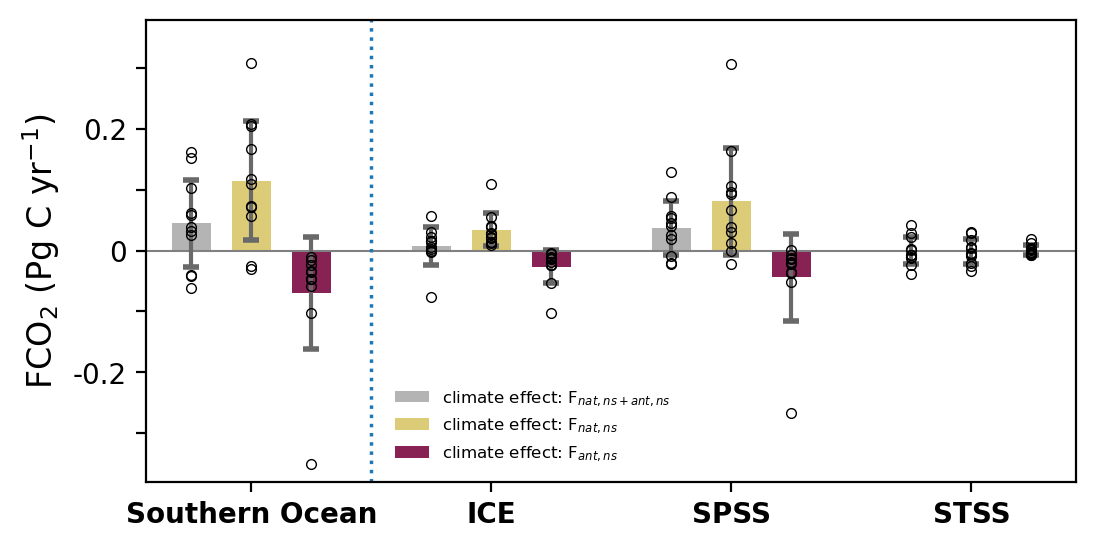

In [15]:
#----
# plot
#----

# for consistency, take FESOM_HR and MOM6 out of the mean contemporary bar
# like that, contemporary = natural + anth + rivers
# if I don't exclude these two, the set of models considered for contemp is different from that for nat and anth
# use a different symbol for these two models
#ind_fesom_hr = models_A.index("FESOM_REcoM_HR")
#print 'Index of FESOM_HR:',ind_fesom_hr
#ind_mom6 = models_A.index("MOM6-Princeton")
#print 'Index of MOM6:',ind_mom6
#ind_not_those = []
#for i, elem in enumerate(models_A):
#    if 'FESOM_REcoM_HR' not in elem:
#        if 'MOM6-Princeton' not in elem:
#            ind_not_those.append(i)
#print 'All inidces except those two:',ind_not_those

factor2 = -1*365.*86400.*12.011/1e15
factor  = 365.*86400.*12.011/1e15 # for river fluxes

width = 0.65
shift = 0.2
fs_text = 12
dpicnt  =200

#color1 = 'darkgreen'#'C2'
#color2 = 'darkgreen'#'mediumseagreen'
#color3 = 'darkgreen'
#color4 = 'darkgreen'#'palegreen'
#color5 = 'darkgreen'#'mediumturquoise'

alpha_clim       = 1.0
alpha_clim_nat   = 1.0#0.6
alpha_clim_anth  = 1.0#0.2

##color1 = (31./255.,120./255.,180./255.) # contemporary, blue
##color3 = (51./255.,160./255.,44./255.) # natural, dark green
#color5 = (251./255.,154./255.,153./255.) # anthropogenic, light red
##color4 = (251./255.,154./255.,153./255.) # CO2 effect, light red
#color1 = (178./255.,223./255.,138./255.) # climate effect, light green

color1 = (180./255.,180./255.,180./255.) # contemporary, grey
color5 = (136./255.,34./255.,85./255.) #(205./255.,92./255.,92./255.) # anthropogenic, dark red
color3 = (221./255.,204./255.,119./255.) # climate effect, sand
    
##color1 = (251./255.,154./255.,153./255.) # contemporary, light red
#color3 = (31./255.,120./255.,180./255.) # natural, dark blue
#color5 = (51./255.,160./255.,44./255.) # anthropogenic, dark green
##color4 = (178./255.,223./255.,138./255.) # CO2 effect, light green
#color1 = (166./255.,206./255.,227./255.) # climate effect, light blue

#natural = '#1f78b4',  # dark blue
#climate_effect = '#a6cee3',  # light blue
#co2_effect = '#b2df8a',  # light green
#anthropogenic = '#33a02c',  # dark green
#contemporary = '#fb9a99' # light red/pink

#166,206,227 # light blue
#31,120,180 # dark blue
#178,223,138 # light green
#51,160,44 # dark green
#251,154,153 # light red


color_dots = 'black'
# markers for each model/data product
circle_size=3.5
edgewidth=0.5
# whiskers for model/data spread
whisker_properties = dict(lw=1.5, capsize=3, capthick=2,ecolor='dimgrey')

panel_label = ''
unit = 'FCO$_{2}$ (Pg C yr$^{-1}$)'

ind_ss1 = -1
ind_ss2 = -2
ind_ss3 = -3
ind_ss4 = -4

x_pos =np.asarray([1,2,3,\
        5,6,7,\
        9,10,11,\
        13,14,15])
x_pos = np.reshape(x_pos,[4,3])

check_numbers = True # option to print some numbers

label1 = 'climate effect: F$_{nat,ns+ant,ns}$' #'climate effect on total FCO$_{2}$'
label2 = 'climate effect: F$_{nat,ns}$' #'climate effect on natural FCO$_{2}$'
label3 = 'climate effect: F$_{ant,ns}$' #'climate effect on anth FCO$_{2}$'

fig, axs = plt.subplots(1,1,figsize=(6,3), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1],\
                                         'height_ratios': [1]})

ax1 = plt.subplot2grid((1,1), (0,0))#, colspan=6)

ax=ax1
ax.hlines(0,np.min(x_pos)-0.75,np.max(x_pos)+0.75,color='grey',linewidth=0.75)

#-----
# subregion: all
#-----
rr=ind_ss1
col=0
#----
# total climate
#----
alpha1 = alpha_clim
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties,label=label1)
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,0],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print ('')
print (subregions[rr]+', avg climate effect: '+str(m_mean))
#----
# climate effect on natural CO2
#----
alpha1 = alpha_clim_nat
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,1],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties,label=label2)
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,1],factor2*biome_area_models_AC[mm,rr]*flux_models_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect on natural CO2: '+str(m_mean))
#----
# climate effect on anthropogenic CO2
#----
alpha1 = alpha_clim_anth
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,2],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties,label=label3)
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,2],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect on anthropogenic CO2: '+str(m_mean))


#-----
# subregion: STSS
#-----
rr=ind_ss2
col=1
#----
# total climate
#----
alpha1 = alpha_clim
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,0],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect: '+str(m_mean))
#----
# climate effect on natural CO2
#----
alpha1 = alpha_clim_nat
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,1],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label=label2)
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,1],factor2*biome_area_models_AC[mm,rr]*flux_models_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect on natural CO2: '+str(m_mean))
#----
# climate effect on anthropogenic CO2
#----
alpha1 = alpha_clim_anth
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,2],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label=label3)
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,2],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect on anthropogenic CO2: '+str(m_mean))


#-----
# subregion: SPSS
#-----
rr=ind_ss3
col=2
#----
# total climate
#----
alpha1 = alpha_clim
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,0],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect: '+str(m_mean))
#----
# climate effect on natural CO2
#----
alpha1 = alpha_clim_nat
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,1],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label=label2)
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,1],factor2*biome_area_models_AC[mm,rr]*flux_models_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect on natural CO2: '+str(m_mean))
#----
# climate effect on anthropogenic CO2
#----
alpha1 = alpha_clim_anth
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,2],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label=label3)
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,2],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect on anthropogenic CO2: '+str(m_mean))

#-----
# subregion: ICE
#-----
rr=ind_ss4
col=3
#----
# total climate
#----
alpha1 = alpha_clim
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,0],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect: '+str(m_mean))
#----
# climate effect on natural CO2
#----
alpha1 = alpha_clim_nat
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,1],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label=label2)
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,1],factor2*biome_area_models_AC[mm,rr]*flux_models_nat_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect on natural CO2: '+str(m_mean))
#----
# climate effect on anthropogenic CO2
#----
alpha1 = alpha_clim_anth
m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
ax.bar(x_pos[col,2],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                error_kw=whisker_properties)#,label=label3)
for mm in range(0,len(models_AC)):
    ax.plot(x_pos[col,2],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_subareas[mm,rr],\
             markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
            markersize=circle_size,markerfacecolor="None")
print (subregions[rr]+', avg climate effect on anthropogenic CO2: '+str(m_mean))


ax.legend(loc='right',bbox_to_anchor=(0.58, 0.12), \
              ncol=1,markerfirst=True,fancybox=False, \
               frameon=False,shadow=False,prop={'size': 6}) 

ax.set_ylabel(unit,fontsize=fs_text)
ax.set_xlim((np.min(x_pos)-0.75,np.max(x_pos)+0.75))
ax.set_xticks([x_pos[0,1],x_pos[1,1],x_pos[2,1],x_pos[3,1]])
ax.set_xticklabels(['Southern Ocean',subregions[ind_ss2],subregions[ind_ss3],subregions[ind_ss4]],\
                   fontweight='bold')
ax.set_ylim((-0.38,0.38))
ylim1,ylim2 = ax.get_ylim()
ax.vlines(4,ylim1,ylim2,linestyle=':',linewidth=1.25)
ax.set_yticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
ax.set_yticklabels(['',-0.2,'',0,'',0.2,''])

for label in ax.yaxis.get_majorticklabels():
        label.set_size(fs_text-2)
        
for label in ax.xaxis.get_majorticklabels():
        label.set_size(fs_text-2)
        #label.set_rotation(90)
        
filename1 = 'fig_S6_bar_plot_climate_effect_on_CO2_flux_nat_vs_anth_'+str(year1)+'_'+str(year2)+'_v2'
plt.savefig(save_to_dir+filename1+'.png',dpi = dpicnt, bbox_inches='tight',format='png')
plt.savefig(save_to_dir+filename1+'.pdf',dpi = dpicnt, bbox_inches='tight',format='pdf')


plt.show()


In [16]:
#----
# plotting function
#----

def plot_bars_for_3_regions(ax,ind_ss,flux_models_nat_ns_subareas,flux_models_anth_ns_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_models_AC,subregions,\
                           panel_label,counter):
    
    factor2 = -1*365.*86400.*12.011/1e15
    factor  = 365.*86400.*12.011/1e15 # for river fluxes

    width = 0.65
    shift = 0.2
    fs_text = 12
    dpicnt  =200

    #color1 = (31./255.,120./255.,180./255.) # contemporary, blue
    color3 = (51./255.,160./255.,44./255.) # natural, dark green
    color5 = (251./255.,154./255.,153./255.) # anthropogenic, light red
    #color4 = (251./255.,154./255.,153./255.) # CO2 effect, light red
    color1 = (178./255.,223./255.,138./255.) # climate effect, light green

  #  #color1 = (251./255.,154./255.,153./255.) # contemporary, light red
  #  color3 = (31./255.,120./255.,180./255.) # natural, dark blue
  #  color5 = (51./255.,160./255.,44./255.) # anthropogenic, dark green
  #  #color4 = (178./255.,223./255.,138./255.) # CO2 effect, light green
  #  color1 = (166./255.,206./255.,227./255.) # climate effect, light blue

    #natural = '#1f78b4',  # dark blue
    #climate_effect = '#a6cee3',  # light blue
    #co2_effect = '#b2df8a',  # light green
    #anthropogenic = '#33a02c',  # dark green
    #contemporary = '#fb9a99' # light red/pink

    #166,206,227 # light blue
    #31,120,180 # dark blue
    #178,223,138 # light green
    #51,160,44 # dark green
    #251,154,153 # light red

    alpha_clim      = 1.0
    alpha_clim_nat  = 1.0#0.6
    alpha_clim_anth = 1.0#0.2

    color_dots = 'black'
    # markers for each model/data product
    circle_size=3.5
    edgewidth=0.5
    # whiskers for model/data spread
    whisker_properties = dict(lw=1.5, capsize=3, capthick=2,ecolor='dimgrey')

    unit = 'FCO$_{2}$ (Pg C yr$^{-1}$)'

    x_pos =np.asarray([1,2,3,\
        5,6,7,\
        9,10,11])
    x_pos = np.reshape(x_pos,[3,3])

    check_numbers = False # option to print some numbers

    label1 = 'climate effect: F$_{nat,ns+ant,ns}$' #'climate effect on total FCO$_{2}$'
    label2 = 'climate effect: F$_{nat,ns}$' #'climate effect on natural FCO$_{2}$'
    label3 = 'climate effect: F$_{ant,ns}$' #'climate effect on anth FCO$_{2}$'

    ax.hlines(0,np.min(x_pos)-0.75,np.max(x_pos)+0.75,color='grey',linewidth=0.75)
    
    #-----
    # subregion 1
    #-----
    rr=ind_ss[0]
    print ('Plot ',subregions[rr])
    col=0
    #----
    # total climate
    #----
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,0],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect: '+str(m_mean))
    #----
    # climate effect on natural CO2
    #----
    alpha1 = alpha_clim_nat
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,1],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label=label2)
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_AC[mm,rr]*flux_models_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect on natural CO2: '+str(m_mean))
    #----
    # climate effect on anthropogenic CO2
    #----
    alpha1 = alpha_clim_anth
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,2],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label=label3)
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect on anthropogenic CO2: '+str(m_mean))


    #-----
    # subregion2
    #-----
    rr=ind_ss[1]
    print ('Plot ',subregions[rr])
    col=1
        # total climate
    #----
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,0],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect: '+str(m_mean))
    #----
    # climate effect on natural CO2
    #----
    alpha1 = alpha_clim_nat
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,1],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label=label2)
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_AC[mm,rr]*flux_models_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect on natural CO2: '+str(m_mean))
    #----
    # climate effect on anthropogenic CO2
    #----
    alpha1 = alpha_clim_anth
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,2],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label=label3)
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect on anthropogenic CO2: '+str(m_mean))


    #-----
    # subregion3
    #-----
    rr=ind_ss[2]
    print ('Plot ',subregions[rr])
    col=2
        # total climate
    #----
    alpha1 = alpha_clim
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,0],m_mean,width,color=color1,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label='climate effect on total FCO$_{2}$')
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,0],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect: '+str(m_mean))
    #----
    # climate effect on natural CO2
    #----
    alpha1 = alpha_clim_nat
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,1],m_mean,width,color=color3,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label=label2)
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,1],factor2*biome_area_models_AC[mm,rr]*flux_models_nat_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect on natural CO2: '+str(m_mean))
    #----
    # climate effect on anthropogenic CO2
    #----
    alpha1 = alpha_clim_anth
    m_mean = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
    m_std  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
    ax.bar(x_pos[col,2],m_mean,width,color=color5,alpha=alpha1,yerr=m_std,\
                    error_kw=whisker_properties)#,label=label3)
    for mm in range(0,len(models_AC)):
        ax.plot(x_pos[col,2],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_subareas[mm,rr],\
                 markeredgecolor=color_dots,marker='o',markeredgewidth=edgewidth,
                markersize=circle_size,markerfacecolor="None")
    print (subregions[rr]+', avg climate effect on anthropogenic CO2: '+str(m_mean))

    
    if counter==1:
        ax.legend(loc='right',bbox_to_anchor=(0.5, 0.82), \
                  ncol=1,markerfirst=True,fancybox=False, \
                   frameon=False,shadow=False,prop={'size': 7}) 
        #ax.legend(loc='right',bbox_to_anchor=(1.0, 0.17), \
        #          ncol=1,markerfirst=False,fancybox=False, \
        #           frameon=False,shadow=False,prop={'size': 6}) 

    if counter>0:
        ax.annotate(panel_label,xy=(-0.18,0.98), xycoords='axes fraction',fontsize=fs_text+1,fontweight='bold')
    else:
        ax.annotate(panel_label,xy=(-0.16,0.98), xycoords='axes fraction',fontsize=fs_text+1,fontweight='bold') 
    
    ax.set_xlim((np.min(x_pos)-0.75,np.max(x_pos)+0.75))
    ax.set_xticks([x_pos[0,1],x_pos[1,1],x_pos[2,1]])
    ax.set_xticklabels([subregions[ind_ss[0]],subregions[ind_ss[1]],subregions[ind_ss[2]]],\
                       fontweight='bold')
    
    if counter==2:
        ax.set_ylim((-0.18,0.18))
        ylim1,ylim2 = ax.get_ylim()
        ax.set_yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15])
        ax.set_yticklabels([-0.15,-0.1,-0.05,0,0.05,0.1,0.15])
        ax.set_ylabel(unit,fontsize=fs_text)
    elif counter==2:
        ax.set_ylim((-0.18,0.18))
        ylim1,ylim2 = ax.get_ylim()
        ax.set_yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15])
        ax.set_yticklabels([-0.15,-0.1,-0.05,0,0.05,0.1,0.15])
        ax.set_ylabel(unit,fontsize=fs_text)
    else:
        ax.set_ylim((-0.07,0.07))
        ylim1,ylim2 = ax.get_ylim()
        ax.set_yticks([-0.06,-0.03,0,0.03,0.06])
        ax.set_yticklabels([-0.06,-0.03,0,0.03,0.06])
        ax.set_ylabel(unit,fontsize=fs_text)
    
        
    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs_text-2)

    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs_text-2)
            

No handles with labels found to put in legend.


Plot  STSS-Atl
STSS-Atl, avg climate effect: 0.001369653210404061
STSS-Atl, avg climate effect on natural CO2: -7.721900100285962e-07
STSS-Atl, avg climate effect on anthropogenic CO2: 0.0013704254004140888
Plot  STSS-Ind
STSS-Ind, avg climate effect: 0.00109730936015053
STSS-Ind, avg climate effect on natural CO2: -0.0018486485997402137
STSS-Ind, avg climate effect on anthropogenic CO2: 0.002945957959890744
Plot  STSS-Pac
STSS-Pac, avg climate effect: -0.00262500951918028
STSS-Pac, avg climate effect on natural CO2: 0.0008775813585721469
STSS-Pac, avg climate effect on anthropogenic CO2: -0.003502590877752428
Plot  SPSS-Atl
SPSS-Atl, avg climate effect: 0.0022827018034189146
SPSS-Atl, avg climate effect on natural CO2: 0.012317018987138576
SPSS-Atl, avg climate effect on anthropogenic CO2: -0.010034317183719662
Plot  SPSS-Ind
SPSS-Ind, avg climate effect: 0.02466193021679619
SPSS-Ind, avg climate effect on natural CO2: 0.044267869096712056
SPSS-Ind, avg climate effect on anthropogenic

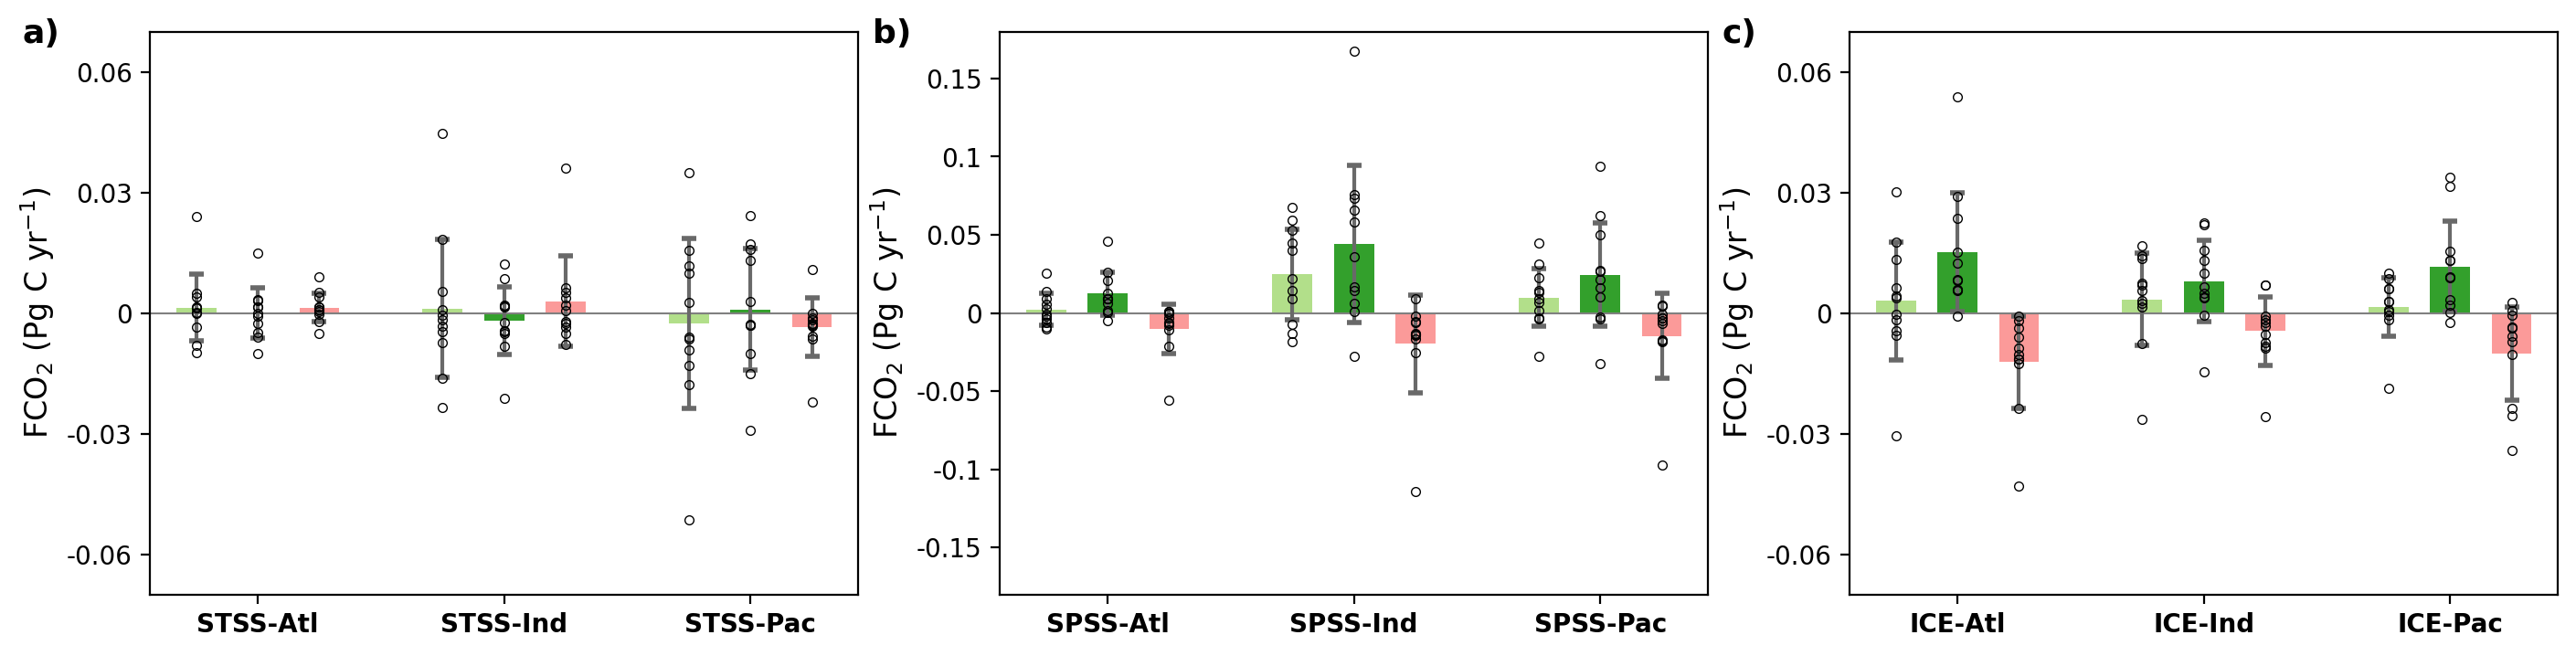

In [18]:
#----
# plot for all nine regions
#----

#('STSS-Atl', 'STSS-Ind', 'STSS-Pac', 
# 'SPSS-Atl', 'SPSS-Ind', 'SPSS-Pac',
# 'ICE-Atl', 'ICE-Ind', 'ICE-Pac', 'STSS', 'SPSS', 'ICE', 'all')

fig, axs = plt.subplots(1,3,figsize=(17,4), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1,1],\
                                         'height_ratios': [1]})

ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax=ax1
plot_bars_for_3_regions(ax,[0,1,2],flux_models_nat_ns_subareas,flux_models_anth_ns_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_models_AC,subregions,'a)',1)

ax=ax2
#ax.set_axis_off()
plot_bars_for_3_regions(ax,[3,4,5],flux_models_nat_ns_subareas,flux_models_anth_ns_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_models_AC,subregions,'b)',2)

ax=ax3
#ax.set_axis_off() 
plot_bars_for_3_regions(ax,[6,7,8],flux_models_nat_ns_subareas,flux_models_anth_ns_subareas,\
                            flux_models_anth_ns_nat_ns_subareas,\
                           biome_area_models_AC,subregions,'c)',3)
        
filename1 = 'figXX_bar_plot_climate_effect_on_CO2_flux_nat_vs_anth_'+str(year1)+'_'+str(year2)+'_9regions'
plt.savefig(save_to_dir+filename1+'.png',dpi = dpicnt, bbox_inches='tight',format='png')
plt.savefig(save_to_dir+filename1+'.pdf',dpi = dpicnt, bbox_inches='tight',format='pdf')

plt.show()



In [19]:
#----
# print some numbers!
#----

print_numbers = True

if print_numbers:

    #----
    # print multi-model averages
    #----
    filename_numbers = 'Fig_S6_numbers_multi_model_averages_climate_effects_only.txt'
    f = open(save_to_dir+filename_numbers, "a")
    print('NOTE: FESOM_HR and MOM6 are not included here',file=f)

    for rr in range(len(subregions)-1, -1, -1):
        # climate effect: simA-simC
        m_mean_clim = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
        m_std_clim  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_nat_ns_subareas[:,rr],axis=0)
        # climate effect on natural: simD-simB
        m_mean_clim_nat = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
        m_std_clim_nat  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_nat_ns_subareas[:,rr],axis=0)
        # climate effect on anthropogenic: simA-simC-simD+simB
        m_mean_clim_anth = np.mean(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)
        m_std_clim_anth  = np.std(factor2*biome_area_models_AC[:,rr]*flux_models_anth_ns_subareas[:,rr],axis=0)

        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        print('----',file=f)
        print('Climate effect (nat,ns+anth,ns), i.e. simA-simC',file=f)
        print ('multi-model mean:',m_mean_clim, file=f)
        print ('multi-model std:',m_std_clim, file=f)
        print('----',file=f)
        print('Climate effect on natural (nat,ns), i.e. simD-simB',file=f)
        print ('multi-model mean:',m_mean_clim_nat, file=f)
        print ('multi-model std:',m_std_clim_nat, file=f)
        print('----',file=f)
        print('Climate effect on anthropogenic (anth,ns), i.e. simA-simC-simD+simB',file=f)
        print ('multi-model mean:',m_mean_clim_anth, file=f)
        print ('multi-model std:',m_std_clim_anth, file=f)
        print('----',file=f)
        print ('##########', file=f)
        print ('', file=f)

    f.close()

    print('done')

done


In [20]:
#-----
# print individual models
#------

if print_numbers:
    #---
    # climate effect on natural
    #---
    filename_numbers = 'Fig_S6_numbers_all_models_climate_effect_on_natural.txt'
    f = open(save_to_dir+filename_numbers, "a")
    print('Climate effect (nat,ns), i.e. simD-simB',file=f)

    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        for mm in range(0,len(models_AC)):
            print (models_AC[mm],factor2*biome_area_models_AC[mm,rr]*flux_models_nat_ns_subareas[mm,rr], file=f)
        print ('##########', file=f)
        print ('', file=f)
    f.close()

    #---
    # climate effect on anthropogenic
    #---
    filename_numbers = 'Fig_S6_numbers_all_models_climate_effect_on_anthropogenic.txt'
    f = open(save_to_dir+filename_numbers, "a")
    print('Climate effect (anth,ns), i.e. simA-simC-simD+simB',file=f)

    for rr in range(len(subregions)-1, -1, -1):
        print('##########', file=f)
        print('Region '+subregions[rr]+':', file=f)
        for mm in range(0,len(models_AC)):
            print (models_AC[mm],factor2*biome_area_models_AC[mm,rr]*flux_models_anth_ns_subareas[mm,rr], file=f)
        print ('##########', file=f)
        print ('', file=f)
    f.close()

    print('done')
    
    

done
